In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random 
import kaggle
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix



## Data extraction
the first step in the project is to gather the data from the resouces. 
for this project we will be using dataset of FER2013 which was a dataset release for kaggle competition.  Source: ##link to the data
    
-download data from kaggle.

-convert CSV to dataframe


In [24]:
#data downloading 
kaggle_dataset = 'deadskull7/fer2013'  
file_name = 'fer2013.csv'  # file name we want to download
data_folder = '../data'

# data directory should be created if it doesnot exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

try:
    #dataset downloaded from kaggle
    kaggle.api.dataset_download_file(dataset=kaggle_dataset, file_name=file_name, path=data_folder)
    # this is the path to the downloaded zip file
    zip_file_path = os.path.join(data_folder, file_name+'.zip')
    
    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)

    # Remove the zip file after extraction
    os.remove(zip_file_path)
    print('Data downloaded and extracted.')

except Exception as e:
    print(f"An error occurred: {e}")

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
Data downloaded and extracted.


In [25]:
#import the csv file obtained and convert it into the pandas dataframe
faces = pd.read_csv('../data/fer2013.csv')
#displaying the top 5(by default) datasets
faces.head()
#we can use faces.tail() for the last 5 datasets and we can give the parameter values inside the parenthesis if we want to display the number of dataset according to the requirements.

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


#Data Exploration

In [26]:
#dataframe.info() method allows us to see the features of the datasets
#this includes their name, count and data types
faces.info()
#there is a method for dataframe called describe() which lets us get statistical analysis on the numerical features of the dataset. 
# For our dataset, we only have one int datatype feature. So we wont be using it
# This method provides information about the min, max, avg, q3, q5,etc.which can be essential for some other analysis.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [27]:
#datafreame.nunique() method gives us the total number of unique values present in the datasets
faces.nunique()

emotion        7
pixels     34034
Usage          3
dtype: int64

## Dataset Description
The given dataset has 3 features which are:
- Emotion: Label encoded feature with 7 different emotions.
    - 0: Angry
    - 1: Digust
    - 2: Fear
    - 3: Happy
    - 4: Sad
    - 5: Surprise
    - 6: Neutral 
- Pixels: This is a flattened array of pixels of a black and white 48x48 pixels face picture in string format
- Usage: Label for the picture whether to use them as training or testing or validation.
    
For our classififcation, we will be generalizing faces into total four categories happy, sad, calm and angry. This will help us in easier recommendation of the music as there is no music that can be helpful for example surprised emotion. We will make a subset of the dataset containing only these 4 emotions and use them for further processes.

In [28]:
#making subset of dataframe
faces = faces[faces['emotion'].isin([0,3,4,6])].reset_index(drop=True)

In [29]:
# value_count gives the total number of discrete value in a column
faces['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
0    4953
Name: count, dtype: int64


Initial Mapping
- 0: Angry
- 1: Digust
- 2: Fear
- 3: Happy
- 4: Sad
- 5: Surprise
- 6: Neutral 

Lets map such that:
- 0 : Anger
- 1 : Happy
- 2 : Sad
- 3 : Neutral

In [30]:
# MAKE SURE YOU DON'T REPLACE TWICE!!
#inplace returns the original value by changing it
faces['emotion'].replace({3:1,4:2,6:3},inplace= True)
faces['emotion'].value_counts()

C:\Users\arati\AppData\Local\Temp\ipykernel_23148\1518662983.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  faces['emotion'].replace({3:1,4:2,6:3},inplace= True)


emotion
1    8989
3    6198
2    6077
0    4953
Name: count, dtype: int64

In [31]:
#let us 
faces.groupby('Usage')['emotion'].value_counts()

Usage        emotion
PrivateTest  1           879
             3           626
             2           594
             0           491
PublicTest   1           895
             2           653
             3           607
             0           467
Training     1          7215
             3          4965
             2          4830
             0          3995
Name: count, dtype: int64

The classes are evenly distributed except the happy class in training

In [32]:
def get_pix(str_pix):
    img = np.array(str_pix.split(),dtype =float) 
    #this will give a list from the string for instance [233,181,135]. 
    #pixels.split() gives a list and np.array converts the list to array
    # For the neural network, the neural networks wants an extra dimension for the color space like rgb or grayscale. Lets add that
    img = img.reshape(48,48,1) # reshape the 1d array to 2d array of dimensions 48x48x1
    return img.astype(np.uint8) #return tuple of img with required datatype and emotion label

In [33]:
faces['pixels'] = faces['pixels'].apply(lambda x: get_pix(x))

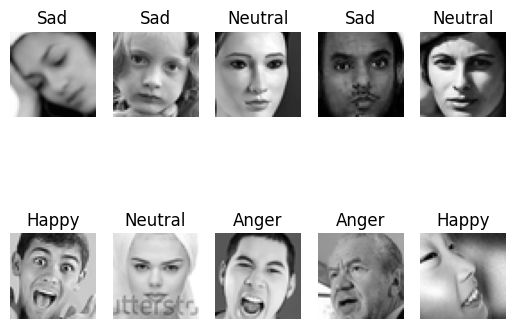

In [34]:
#Lets check some of the faces from our dataset now they are in required array format.
# We can use matplotlib to plot the pixel values
samples = faces.sample(n = 10).reset_index() #getting 10 random samples
emotion_map = {0:'Anger',1:'Happy',2:'Sad',3:'Neutral'} # making a dictionary to  map the labels 
fig,axes = plt.subplots(2,5) 
for index, row in samples.iterrows():
    axes[(index)//5,index%5].imshow(row['pixels'],cmap='gray')
    axes[(index)//5,index%5].set_title(emotion_map[row['emotion']])
    axes[(index)//5,index%5].set_axis_off()
plt.show()

In [35]:
faces['Usage'].value_counts()

Usage
Training       21005
PublicTest      2622
PrivateTest     2590
Name: count, dtype: int64

##Train Test Validation Split

Why do we split into train test and validation?

When building Neural Network, the model uses the training data to build the model and adjust the parameters such as weights.

Validation data is used to validate the model such as adjusting hyperparameters, avoid overfitting and for early stoping.

The testing data is used as completely new data to the model. It is essential as there will be data leaks with validation data and if that is used as testing the model will be biased since it has already seen that data.

In [36]:
train_x = faces[faces['Usage'] == 'Training']['pixels']  #First subset the dataframe according to the value in Usage and then take the pixels as the independent variable for training
train_y = faces[faces['Usage'] == 'Training']['emotion']  #First subset the dataframe according to the value in usage and then take the emotion as the dependent variable for training
val_x = faces[faces['Usage'] == 'PrivateTest']['pixels']  #First subset the dataframe according to the value in Usage and then take thpixels as the independent variable for validation
val_y = faces[faces['Usage'] == 'PrivateTest']['emotion']  #First subset the dataframe according to the value in Usage and then take the emotion as the dependent variable for validation
test_x = faces[faces['Usage'] == 'PublicTest']['pixels']  #First subset the dataframe according to the value in Usage and then take the pixels as the independent variable for testing
test_y = faces[faces['Usage'] == 'PublicTest']['emotion']  #First subset the dataframe according to the value in Usage and then take the emotion as the dependent variable for testing

In [37]:
num_classes = 4
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

# CRNO stands for Convert, 
# Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

from keras.utils import to_categorical
def CRNO(X,y, dataName):
    data_X = np.array(X.tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(y, num_classes)  
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

    
train_X, train_Y = CRNO(train_x,train_y,"train") #training data
val_X, val_Y     = CRNO(val_x,val_y, "val") #validation data
test_X, test_Y   = CRNO(test_x,test_y, "test") #test data

train _X shape: (21005, 48, 48, 1),  train _Y shape: (21005, 4)
val _X shape: (2590, 48, 48, 1),  val _Y shape: (2590, 4)
test _X shape: (2622, 48, 48, 1),  test _Y shape: (2622, 4)


In [38]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

c:\Users\arati\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             

 Total params: 2,137,604 (8.15 MB)

 Trainable params: 2,134,020 (8.14 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [40]:
from sklearn.utils.class_weight import compute_class_weight

# Adding Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can monitor 'val_accuracy' as well
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model with the best weights
)

class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
class_weights_dict = dict(enumerate(class_weights))
history = model.fit(train_X, train_Y,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(val_X, val_Y),
                    class_weight = class_weights_dict, #for class imbalance 
                    callbacks = [early_stopping]) 

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.3678 - loss: 1.3845 - val_accuracy: 0.2529 - val_loss: 1.7014
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2314s 7s/step - accuracy: 0.5659 - loss: 1.0394 - val_accuracy: 0.5614 - val_loss: 1.0233
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 31208s 95s/step - accuracy: 0.6525 - loss: 0.8645 - val_accuracy: 0.5633 - val_loss: 1.0981
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 54266s 165s/step - accuracy: 0.6962 - loss: 0.7756 - val_accuracy: 0.6429 - val_loss: 0.8723
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 45738s 139s/step - accuracy: 0.7429 - loss: 0.6746 - val_accuracy: 0.6093 - val_loss: 0.9831
Epoch 6/50
 58/329 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8014 - loss: 0.5469 

In [ ]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [ ]:
# Model Inference
preds = model.predict(test_X)
y_pred = np.argmax(preds , axis = 1 )

In [ ]:
print(classification_report(np.argmax(test_Y, axis = 1 ),y_pred,digits=3))